((1011347, 5), (1011347, 5), (1, 5))

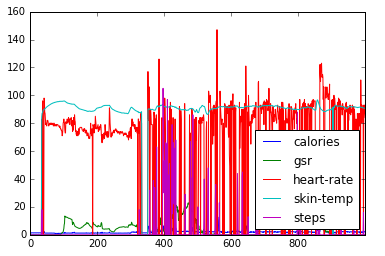

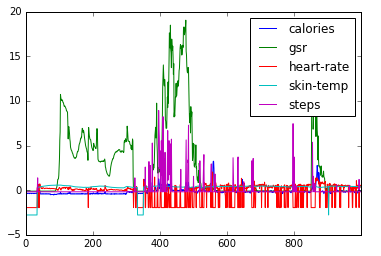

In [17]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The smartwatch historical/time-seris data to visualize
data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
watch_txn = pd.read_csv(data_path_1xn)

# txn: time-space from the space-time theory
watch_txn.head()

# Exploring the data rows-t and cols-n
watch_txn[:20]

# Data: cleaning
# Getting rid of NaN
watch_txn = watch_txn.fillna(value=0.0)
watch_txn[:100]

# # Plotting the smartwatch data
watch_txn[:1000].plot() #x='dteday', y='cnt'

# Data: Preprocessing 
# Batch normalization
features_1x5 = ['calories', 'gsr', 'heart-rate', 'skin-temp', 'steps']

# Store scalings in a dictionary so we can convert back later
scaled_features_5x2 = {}
for each_name in features_1x5:
    mean_1x1_val, std_1x1_val = watch_txn[each_name].mean(), watch_txn[each_name].std() # std: standard dev. = square-root of MSE/Variance
    scaled_features_5x2[each_name] = [mean_1x1_val, std_1x1_val]
    watch_txn.loc[:, each_name] = (watch_txn[each_name] - mean_1x1_val)/std_1x1_val

# Drop date from the dataset
watch_txn = watch_txn.drop(labels='date', axis=1)

# Visualize the data again to double-check visually again
watch_txn[:1000].plot()

X = np.array(watch_txn)
y = np.array(watch_txn[1:])
last_row = np.array([np.zeros_like(y[0])])
y = np.row_stack((y, last_row))
y.shape, X.shape, last_row.shape

In [24]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class RNN(nn.NN):

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(C / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for l in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()

        h, h_cache = l.tanh_forward(X @ Wxh + hprev @ Whh + bh)
        y, y_cache = l.fc_forward(h, Why, by)

        cache = X, Whh, h, hprev, y, h_cache, y_cache, Wxh

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, Whh, h, hprev, y, h_cache, y_cache, Wxh = cache

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dh = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dh
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            #             X_one_hot = np.zeros(self.D)
            #             X_one_hot[X] = 1.
            #             y = X_one_hot.reshape(1, -1)
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        dy = 0.5 * (y_pred - y_train) / m

        return dy

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size=100):
#         chars = [self.idx2char[X_seed]]
#         idx_list = list(range(self.vocab_size))
#         X = X_seed
        
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())

        y_pred = []
        y = X_seed.reshape(1, -1)

        for _ in range(size - 1):
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
            y_pred.append(y)

#         return ''.join(chars)
        return np.array(y_pred)

In [25]:
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)

    idx = 0
    state = nn.initial_state()
    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        idx += 1

        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        dX, grads = nn.train_backward(dys, caches)
        nn.losses['train'].append(loss)

        # Print training loss and test sample
        if iter % print_after == 0:
            print('Iter-{} loss: {:.4f}'.format(iter, loss))
#             sample = nn.test(X_mini[0], state)
#             print(sample)

        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [26]:
# hyper parameters
n_iter = 13000 # epochs
alpha = 1e-3 # learning_rate
print_after = 1000 # print lossof train, valid, or test
time_step = 100 # width of the model or minibatch
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X.shape[1] # number of input features/dimensions

In [ ]:
net = RNN(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1000 loss: 0.9996
[[[ -4.00560179e-01  -9.36053564e-01  -5.51767037e-03   4.32718144e-01
    -4.00275214e-01]]

 [[  4.19916462e-01  -3.78752904e+00   5.77525847e-01   6.92902882e-01
    -1.88856705e+00]]

 [[  9.54634992e-01  -5.45374228e+00   1.82562274e+00  -8.76097647e-01
    -4.24647068e+00]]

 [[  1.69810544e-01  -3.77469807e+00   1.71261478e+00   9.29093193e-01
     1.41113408e+00]]

 [[  5.60357529e-02  -4.12389437e+00   1.32671136e+00  -1.21528232e+00
     2.81842480e+00]]

 [[  4.24554415e-01  -3.63745386e+00  -1.68485777e+00  -2.04449575e+00
     5.14515453e+00]]

 [[  1.32127095e+00  -8.59630438e+00  -4.67297833e-01  -3.52459302e+00
     4.10492454e+00]]

 [[  9.82824772e-01  -1.15226736e+01  -1.97941644e-01  -2.17234715e+00
     6.97313268e-01]]

 [[ -2.81177435e-01  -9.94564151e+00   1.69690031e+00  -1.35647249e+00
     8.28373876e-01]]

 [[ -3.02758225e-01  -1.10166524e+01   1.29376096e+00  -5.25306130e-01
     3.72426987e-01]]

 [[ -3.71835214e-01  -1.07788030e+01 

Iter-2000 loss: 0.0354
[[[ -1.13973734e+00  -5.87758949e-02  -2.73935242e+00  -2.49145766e+00
     1.62076204e-01]]

 [[  1.09629434e-01   4.54582461e-01  -2.40323060e+00  -1.42332781e+00
     1.45882441e+00]]

 [[  1.53048487e+00   1.98997885e+00  -4.69551077e-02   5.11358070e-01
     1.31940176e+00]]

 [[  8.98356564e-01   3.98799054e+00  -1.78711711e+00  -7.08236260e-01
     4.82069667e+00]]

 [[  9.68966325e-01   4.02575493e+00  -3.50947494e+00  -1.10077981e+00
     2.74869869e+00]]

 [[  9.77683710e-01   3.51214979e+00  -3.73874305e+00  -1.91102142e-01
     3.31479888e+00]]

 [[  2.81677133e+00   4.63549830e+00  -5.03496717e+00   3.50798766e-01
     1.86316309e+00]]

 [[  9.50258483e-01   3.74042174e+00  -3.25675485e+00  -1.30557957e+00
     3.87278874e+00]]

 [[  1.65335931e+00   4.80748980e+00  -3.59118844e+00   2.30748388e-01
     3.20518317e+00]]

 [[  2.33784155e+00   4.33834374e+00  -3.76176978e+00  -3.88360075e-01
     3.28486578e+00]]

 [[  7.23362405e-01   3.54915018e+00 

Iter-3000 loss: 1.8074
[[[ -9.26421682e-02  -5.91929612e-02  -1.50653263e+00   4.39757627e-01
    -3.94247894e-01]]

 [[  1.72476643e-01   3.34558932e-01  -1.44819208e+00   2.27612290e-01
    -7.58986583e-01]]

 [[  2.75923667e-01   9.74794015e-01  -1.90562310e+00  -2.89942616e-01
    -5.24389940e-01]]

 [[  3.62554100e-01   1.67152229e+00  -1.74081838e+00  -2.64355008e-01
     8.64211441e-02]]

 [[  2.82035196e-02   1.94267399e+00  -1.50919025e+00  -3.22012972e-01
     1.64833885e+00]]

 [[  4.61880291e-01   1.44542668e+00  -8.80467275e-01   2.77714155e-01
     1.56245331e+00]]

 [[  4.16043101e-01   9.09888510e-01  -4.45974294e-01  -8.69130825e-02
     1.31867173e+00]]

 [[  6.13415183e-01   7.80142037e-01  -4.01405374e-01  -1.33973981e-01
     7.17132100e-01]]

 [[  1.73131113e-01   9.92031363e-01  -7.48316757e-01  -4.51581933e-01
     1.26607195e+00]]

 [[  6.29811753e-01   1.10606620e+00  -9.11145749e-01  -2.61338819e-01
     9.81424190e-01]]

 [[  3.54719013e-01   1.58925658e+00 

Iter-4000 loss: 1.4293
[[[-0.34484999 -0.00427986 -0.23691094  0.47598314 -0.15843158]]

 [[-0.12002251  0.44314367 -0.37962813  0.66405051 -0.08493908]]

 [[ 0.0235605   0.64738451  0.02505779  0.71700551 -0.23690055]]

 [[-0.42508391  0.02958268 -0.07187476  0.48400877  0.13884875]]

 [[-0.63564625 -0.34458659 -0.16873307  0.434192   -0.31394326]]

 [[-0.62134157 -0.24407898 -0.29165455  0.24386061 -0.45061319]]

 [[-0.51050117  0.01621608 -0.31452501  0.21398486 -0.43648603]]

 [[-0.43007     0.10668406 -0.32050326  0.27644538 -0.3451946 ]]

 [[-0.44703885  0.00994265 -0.30194258  0.32646438 -0.3183421 ]]

 [[-0.51268725 -0.0939796  -0.30089473  0.33219299 -0.37324111]]

 [[-0.53387856 -0.09695799 -0.3185529   0.30368664 -0.42242584]]

 [[-0.51072236 -0.04281067 -0.33490643  0.28543508 -0.42867617]]

 [[-0.48803509 -0.01054823 -0.34499875  0.28933971 -0.40929949]]

 [[-0.48846469 -0.02077953 -0.34988109  0.2971983  -0.39736772]]

 [[-0.5022846  -0.04101754 -0.35588345  0.29611336 -0

Iter-6000 loss: 0.0048
[[[-0.2444945  -0.40111382 -2.42490241 -2.70458609 -0.23656347]]

 [[-0.40503647 -1.00816541 -2.10646332 -2.33628179 -0.52172181]]

 [[-0.75524094 -1.04612199 -2.05058155 -2.42618542 -0.94120723]]

 [[-0.36848087 -0.42843455 -2.22563661 -2.82531448 -1.17115073]]

 [[-0.54394178 -0.36270754 -2.07456215 -2.92221438 -0.23533637]]

 [[-0.14767529  0.06451645 -2.04099515 -2.94216985 -0.41894779]]

 [[-0.38193666 -0.19823393 -1.92444057 -2.91199192 -0.04035273]]

 [[-0.12347492  0.01979528 -1.90206076 -2.85857476 -0.24985245]]

 [[-0.27115227 -0.14493968 -1.85538341 -2.81260032 -0.04490017]]

 [[-0.11438517 -0.00834137 -1.8592229  -2.79298248 -0.18272463]]

 [[-0.23181145 -0.11885678 -1.84414822 -2.77813748 -0.06662807]]

 [[-0.1381716  -0.03459346 -1.85829837 -2.78034155 -0.1530355 ]]

 [[-0.21431718 -0.10132942 -1.85143262 -2.77642117 -0.09273728]]

 [[-0.16049764 -0.05530696 -1.86217339 -2.78028775 -0.1352813 ]]

 [[-0.19848515 -0.08744694 -1.85562338 -2.77772328 -0

Iter-8000 loss: 0.1480
[[[-0.24564841 -0.17130144 -1.99112724 -2.60988694 -0.0679753 ]]

 [[-0.22872295 -0.29352471 -1.90114876 -2.76900604 -0.34491996]]

 [[-0.27611017 -0.25807511 -1.97690212 -2.76427362 -0.08135718]]

 [[-0.07998836 -0.10304911 -1.90654104 -2.77243301 -0.26524337]]

 [[-0.14691354 -0.15199252 -1.9020894  -2.76757777 -0.13388872]]

 [[-0.10454708 -0.12425732 -1.8903326  -2.75725543 -0.1988033 ]]

 [[-0.11777569 -0.1469134  -1.88648901 -2.75409527 -0.16255915]]

 [[-0.10274487 -0.13736475 -1.88264594 -2.75102856 -0.18098884]]

 [[-0.10380336 -0.14278362 -1.8786082  -2.74990425 -0.16912995]]

 [[-0.0977746  -0.13954102 -1.87553012 -2.74828264 -0.17350684]]

 [[-0.09654934 -0.14105276 -1.87261023 -2.74722413 -0.16953058]]

 [[-0.09360607 -0.14014483 -1.87042554 -2.74611196 -0.17025506]]

 [[-0.09216365 -0.14055944 -1.86847387 -2.74527873 -0.16876142]]

 [[-0.09045014 -0.14030345 -1.86693586 -2.7445223  -0.16861775]]

 [[-0.08929435 -0.14040913 -1.86561242 -2.74391985 -0

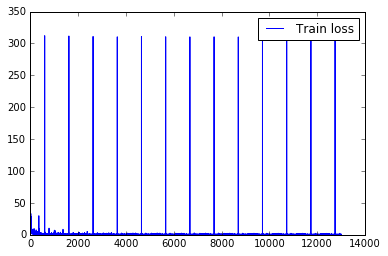

In [16]:
# Display the learning curve and losses for training, validation, and testing
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.legend()